In [1]:
import pandas as pd
import json
import os

Evaluation setup:  
* Embedding model - Text Embedding 004 (Google)  
* LLM - Gemini 2.5 Flash  


## RAGAS Answer Correctness:

The assessment of Answer Correctness involves measuring the accuracy of the generated answer when compared to the ground truth. This evaluation relies on the ground truth and the answer, with scores ranging from 0 to 1. A higher score indicates a closer alignment between the generated answer and the ground truth, signifying better correctness.
Answer correctness  is computed as the sum of factual correctness and the semantic similarity between the given answer and the ground truth.  

Factual correctness is a metric that compares and evaluates the factual accuracy of the generated response with the reference. This metric is used to determine the extent to which the generated response aligns with the reference. The factual correctness score ranges from 0 to 1, with higher values indicating better performance. To measure the alignment between the response and the reference, the metric uses the LLM to first break down the response and reference into claims and then uses natural language inference to determine the factual overlap between the response and the reference. Factual overlap is quantified using precision, recall, and F1 score, which can be controlled using the mode parameter. By default, the mode is set to F1, you can change the mode to precision or recall by setting the mode parameter.

Answer similarity is calculated by following steps:  
Step 1: Vectorize the ground truth answer using the embedding model.  
Step 2: Vectorize the generated answer using the same embedding model.  
Step 3: Compute the cosine similarity between the two vectors.  
        
By default "text-embedding-ada-002" model is used. In that evaluation, we used Text Embedding 004 (Google).  

Final score is created by taking a weighted average of the factual correctness (F1 score) and the semantic similarity. 
(By default, there is a 0.75 : 0.25 weighting.)   

Total API Calls: 4  
* 1 LLM call to produce the "simple statements  
* 1 LLM call to determine the true positives, false positives, and false negatives  
* 1 embedding call to embed the context  
* 1 embedding call to embed the AI answer  

### Unsuccesful experiment with Gemini 2.5 flash:  
Because the generated results are non-deterministic, I run evaluation 3 times and calculate the mean. To evaluate 370 questions x 3 times x 2 (vanilla and RAG) X 4 API calls = 8880 API calls total for one set of results. When I decided to play with Gemini 2.5 flash, ​I also calculated other metrics, in total it cost 16000 API calls and 167 dollars.

**Conclusion**: I will stick with Gemini 2.0 flash model as a main judge for the rest of the project.

I feel like RAGAS use much more in terms of LLM calls than just 4 as they say in documentation. I didn't examine it properly, but there is a [source code](https://github.com/explodinggradients/ragas/blob/main/ragas/src/ragas/metrics/_answer_correctness.py).
There is a [compaint](https://www.reddit.com/r/LangChain/comments/1dbmqii/i_spent_700_on_evaluating_100_rag_qa_set_using/) about RAGAS costing 700$ for 100 QA set.      


Sources:  
* [RAGAS Docs for answer correctness](https://docs.ragas.io/en/v0.1.21/concepts/metrics/answer_correctness.html)  
 
https://github.com/dkhundley/llm-rag-guide/blob/main/notebooks/ragas.ipynb  
https://docs.ragas.io/en/stable/references/embeddings/#ragas.embeddings.embedding_factory  
https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/factual_correctness/#factual-correctness  
https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/semantic_similarity/  

In [ ]:
file_name = "test_dataset_together_meta-llama_Llama-4-Scout-17B-16E-Instruct_top5_answered.json"
base_name = file_name.replace('.json', '')

    # Use forward slashes or os.path.join for better cross-platform compatibility
VANILLA_ANSWER_CORRECTNESS = f"{base_name}_vanilla_answer_correctness_evaluated.json"
RAG_ANSWER_CORRECTNESS = f"{base_name}_rag_answer_correctness_evaluated.json"
RAG_ANSWER_SIMILARITY = f"{base_name}_rag_answer_similarity_evaluated.json"
VANILLA_ANSWER_SIMILARITY = f"{base_name}_vanilla_answer_similarity_evaluated.json"
RAG_ANSWER_RELEVANCY = f"{base_name}_rag_answer_relevancy_evaluated.json"
RAG_FAITHFULNESS = f"{base_name}_rag_faithfulness_evaluated.json"

with open(VANILLA_ANSWER_CORRECTNESS, 'r', encoding='utf-8') as f:
    data = json.load(f)   
df_1 = pd.DataFrame(data)

with open(RAG_ANSWER_CORRECTNESS, 'r', encoding='utf-8') as f:
    data = json.load(f) 
df_2 = pd.DataFrame(data)
df_2 = df_2[["Modified Questions", 
                 "Answer Correctness for RAG run 1", 
                 "Answer Correctness for RAG run 2",
                 "Answer Correctness for RAG run 3",
                 "Mean Answer Correctness for RAG"]]
    
merged_df = pd.merge(df_1, df_2, on="Modified Questions", how="inner")
# Calculate overall means
vanilla_mean = merged_df['Mean Answer Correctness for vanilla'].mean()
rag_mean = merged_df['Mean Answer Correctness for RAG'].mean()
    
print(f"Overall Mean Answer Correctness for Vanilla: {vanilla_mean:.4f}")
print(f"Overall Mean Answer Correctness for RAG: {rag_mean:.4f}")
print(f"Difference (RAG - Vanilla): {rag_mean - vanilla_mean:.4f}")   



Overall Mean Answer Correctness for Vanilla: 0.6058
Overall Mean Answer Correctness for RAG: 0.5695
Difference (RAG - Vanilla): -0.0364


Again, vanilla LLM response is evaluated higher than RAG-enhanced. 

## RAGAS Answer semantic similarity  

This evaluation is based on the ground truth and the answer, with values falling within the range of 0 to 1. A higher score signifies a better alignment 
between the generated answer and the ground truth.  
Step 1: Vectorize the ground truth answer using the specified embedding model.  
Step 2: Vectorize the generated answer using the same embedding model.  
Step 3: Compute the cosine similarity between the two vectors.  

The metric is a part of RAGAS Answer Correctness metric. The Answer Correctness's final score is created by taking a weighted average of the factual correctness (F1 score) and the semantic similarity. 
(By default, there is a 0.75 : 0.25 weighting.)   


Total API Calls: 2
* 1 embedding call to embed the ground truth
* 1 embedding call to embed the AI answer  

The metric is produced much faster (around 30 minutes for the whole set of results). It is 25% component of Answer Correctness metric.  
Since the output is deterministic, we run evaluation only once for each question.   

Sources:  
* [Ragas Docs for semantic similarity](https://docs.ragas.io/en/v0.1.21/concepts/metrics/semantic_similarity.html)   
* https://github.com/dkhundley/llm-rag-guide/blob/main/notebooks/ragas.ipynb

In [ ]:

with open(RAG_ANSWER_SIMILARITY, 'r', encoding='utf-8') as f:
    data = json.load(f) 
df_3 = pd.DataFrame(data)
df_3 = df_3[["Modified Questions", 
            "Answer Semantic Similarity for rag"]]


with open(VANILLA_ANSWER_SIMILARITY, 'r', encoding='utf-8') as f:
    data = json.load(f) 
df_4 = pd.DataFrame(data)
df_4 = df_4[["Modified Questions", 
            "Answer Semantic Similarity for vanilla"]]

merged_df = pd.merge(merged_df, df_3, on="Modified Questions", how="inner")
merged_df = pd.merge(merged_df, df_4, on="Modified Questions", how="inner")

# Calculate overall means
rag_similarity_mean = merged_df['Answer Semantic Similarity for rag'].mean()
vanilla_similarity_mean = merged_df['Answer Semantic Similarity for vanilla'].mean()
print(f"Overall Mean Answer Semantic Similarity for RAG: {rag_similarity_mean:.4f}")
print(f"Overall Mean Answer Semantic Similarity for Vanilla: {vanilla_similarity_mean:.4f}")
print(f"Difference (RAG - Vanilla): {rag_similarity_mean - vanilla_similarity_mean:.4f}")

# Group by psychiatric category
category_stats = merged_df.groupby('psychiatric_category').agg({
        'Answer Semantic Similarity for vanilla': 'mean',
        'Answer Semantic Similarity for rag': 'mean'}).round(4)
    
    # Flatten column names
category_stats.columns = ['Vanilla_Mean', 'RAG_Mean']
    
    # Add difference column
category_stats['Difference (RAG - Vanilla)'] = (category_stats['RAG_Mean'] - 
                                                   category_stats['Vanilla_Mean']).round(4)
    
    # Sort by difference to see which categories benefit most from RAG
category_stats = category_stats.sort_values('Difference (RAG - Vanilla)', ascending=False)
    
display(category_stats)

Overall Mean Answer Semantic Similarity for RAG: 0.8752
Overall Mean Answer Semantic Similarity for Vanilla: 0.8794
Difference (RAG - Vanilla): -0.0042


,Vanilla_Mean,RAG_Mean,Difference (RAG - Vanilla)
psychiatric_category,,,
Eating Disorders,0.8511,0.8656,0.0145
Somatic Disorders,0.8635,0.8762,0.0127
Personality Disorders,0.8951,0.9062,0.0111
Anxiety Disorders,0.8841,0.8850,0.0009
Other Mental Disorders,0.8745,0.8709,-0.0036
Dissociative Disorders,0.9364,0.9323,-0.0041
Bipolar Disorders,0.8830,0.8783,-0.0047
Trauma and Stressor Related Disorders,0.8932,0.8849,-0.0083
Schizophrenia Spectrum and Other Psychotic Disorders,0.8835,0.8752,-0.0083


# RAG Metrics  
## RAGAS Faithfulness 
Faithfulness measures the factual consistency of the generated answer against the given context. It is calculated from the answer and the retrieved context. The answer is scaled to the (0, 1) range. The higher the better. 
The generated answer is regarded as faithful if all the claims made in the answer can be inferred from the given context.  
At the first step, the generated answer is broken down into individual statements.     
Then each of these claims is cross-checked with the given context to determine if it can be inferred from the context.    
The final score is calculated by dividing the number of claims that can be inferred from the context by the total number of claims in the generated response.  



Groundedness, sometimes referred to as faithfulness, measures whether the response is based completely on the context. It validates that the response isn't using information other than what exists in the context. A low groundedness metric indicates that the language model might be outputting inaccurate or nonsensical responses.  A low groundedness calculation indicates that the language model doesn't see the chunks as relevant. You should evaluate whether you need to add data to your collection, adjust your chunking strategy or chunk size, or fine-tune your prompt.  

Source:  
* [RAGAS Docs for Faitfulness](https://docs.ragas.io/en/v0.1.21/concepts/metrics/faithfulness.html)   
* https://learn.microsoft.com/en-us/azure/architecture/ai-ml/guide/rag/rag-llm-evaluation-phase  


In [4]:
with open(RAG_FAITHFULNESS, 'r', encoding='utf-8') as f:
        data = json.load(f) 
df_3 = pd.DataFrame(data)
df_3 = df_3[["Modified Questions", 
                "faithfulness for RAG run 1",
                "faithfulness for RAG run 2",
                "faithfulness for RAG run 3",
                "Mean faithfulness for RAG"]]
    
merged_df = pd.merge(merged_df, df_3, on="Modified Questions", how="inner")

faithfulness_mean = merged_df['Mean faithfulness for RAG'].mean()
print(f"Overall Mean Faithfulness for RAG: {faithfulness_mean:.4f}")

Overall Mean Faithfulness for RAG: 0.2678


Only 26% of retrieved statements are used. 

## RAGAS Answer Relevance  

The Answer Relevance metric evaluates to what extent the generated answer address the provided question. The answer is considered relevant if it directly addressess the question.    
Step 1: Reverse-engineer ‘n’ variants of the question from the generated answer using a LLM (prompt: "Generate a question for the given answer.
answer: [answer])")  
Step 2: Generate embedding for all the questions. Calculate the mean cosine similarity between the generated questions and the actual question by the following formula:     
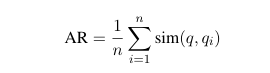  

The Answer Relevance doesn't assess factual correctness of generated answer but rather penalises redundant or insufficient answers.  

Total API Calls by default: 4  
* 1 LLM call to generate the question based on the answer (by default - 3 question)  
* 1 embedding call for each generated question   (by default - 3) 
* 1 embedding call to embed the original question  

Sources:  
* [RAGAS Documentation](https://docs.ragas.io/en/v0.1.21/concepts/metrics/answer_relevance.html)  
* [Original RAGAS paper](https://arxiv.org/abs/2309.15217)  

In [16]:
with open(RAG_ANSWER_RELEVANCY, 'r', encoding='utf-8') as f:
    data = json.load(f) 

df_4 = pd.DataFrame(data)
df_4 = df_4[["Modified Questions",
            "answer_relevancy for RAG run 1",
    "answer_relevancy for RAG run 2",
    "answer_relevancy for RAG run 3",
    "Mean answer_relevancy for RAG"]]
merged_df = pd.merge(merged_df, df_4, on="Modified Questions", how="inner")

relevancy_mean = merged_df['Mean answer_relevancy for RAG'].mean()
print(f"Overall Mean Relevancy for RAG: {relevancy_mean:.4f}")

# Group by psychiatric category
category_stats = merged_df.groupby('psychiatric_category').agg({
        'Mean answer_relevancy for RAG': 'mean'}).round(4)
    
    # Flatten column names
category_stats.columns = ['RAG_Mean']
       
# Sort by difference to see which categories benefit most from RAG
category_stats = category_stats.sort_values('RAG_Mean', ascending=False)
    
print(category_stats)
             

Overall Mean Relevancy for RAG: 0.7071
                                                    RAG_Mean
psychiatric_category                                        
Dissociative Disorders                                0.8022
Anxiety Disorders                                     0.7822
Eating Disorders                                      0.7656
Obsessive-Compulsive Disorders                        0.7543
Depressive Disorders                                  0.7442
Personality Disorders                                 0.7439
Trauma and Stressor Related Disorders                 0.7069
Schizophrenia Spectrum and Other Psychotic Diso...    0.7028
Somatic Disorders                                     0.6944
Bipolar Disorders                                     0.6814
Other Mental Disorders                                0.6642


## Final function to generate report 
(work in progress)

In [17]:

def process_files(file_name, model_name='Llama-4-Scout'):
    '''
    The function will output full report for the set of results for one model.

    '''
    base_name = file_name.replace('.json', '')

    # Files with answer similarity results
    VANILLA_ANSWER_SIMILARITY = f"{base_name}_vanilla_answer_similarity_evaluated.json"
    RAG_ANSWER_SIMILARITY = f"{base_name}_rag_answer_similarity_evaluated.json"
    RAG_FAITHFULNESS = f"{base_name}_rag_faithfulness_evaluated.json"
    VANILLA_ANSWER_RELEVANCE = f"{base_name}_vanilla_answer_relevancy_evaluated.json"
    RAG_ANSWER_RELEVANCE = f"{base_name}_rag_answer_relevancy_evaluated.json"

    
    print("\n" + "=" * 80 + "\n")
    print(f"Evaluation of {model_name} Results:\n")

    # ANSWER SIMILARITY - BOTH VANILA AND RAG
  
    
    with open(VANILLA_ANSWER_SIMILARITY, 'r', encoding='utf-8') as f:
        data = json.load(f) 
    vanilla_answer_similarity = pd.DataFrame(data)


    with open(RAG_ANSWER_SIMILARITY, 'r', encoding='utf-8') as f:
        data = json.load(f) 
    rag_answer_similarity = pd.DataFrame(data)
    rag_answer_similarity = rag_answer_similarity[["Modified Questions", 
            "Answer Semantic Similarity for rag"]]
    
    merged_df = pd.merge(vanilla_answer_similarity, rag_answer_similarity, on="Modified Questions", how="inner")
    

    # Calculate overall means
    print("Answer Semantic Similarity Results:")
    vanilla_similarity_mean = merged_df['Answer Semantic Similarity for vanilla'].mean()
    rag_similarity_mean = merged_df['Answer Semantic Similarity for rag'].mean()
    print(f"Overall Mean Answer Semantic Similarity for RAG: {rag_similarity_mean:.4f}")
    print(f"Overall Mean Answer Semantic Similarity for Vanilla: {vanilla_similarity_mean:.4f}")
    print(f"Difference (RAG - Vanilla): {rag_similarity_mean - vanilla_similarity_mean:.4f}")

    # Group by psychiatric category
    category_stats_answer_similarity = merged_df.groupby('psychiatric_category').agg({
            'Answer Semantic Similarity for vanilla': 'mean',
            'Answer Semantic Similarity for rag': 'mean'}).round(4)
        
    
    category_stats_answer_similarity.columns = ['Vanilla_Mean', 'RAG_Mean']  
    # Add difference column
    category_stats_answer_similarity['Difference (RAG - Vanilla)'] = (category_stats_answer_similarity['RAG_Mean'] - 
                                                    category_stats_answer_similarity['Vanilla_Mean']).round(4) 
    # Sort by difference
    category_stats_answer_similarity = category_stats_answer_similarity.sort_values('Difference (RAG - Vanilla)', ascending=False)
        
    display(category_stats_answer_similarity)

    
    # EVALUATE RAG TRIAD - FAITFULNESS
    with open(RAG_FAITHFULNESS, 'r', encoding='utf-8') as f:
        data = json.load(f) 
    rag_faithfulness = pd.DataFrame(data)
    rag_faithfulness = rag_faithfulness[["Modified Questions", 
                "faithfulness for RAG run 1",
                "faithfulness for RAG run 2",
                "faithfulness for RAG run 3",
                "Mean faithfulness for RAG"]]
    
    merged_df = pd.merge(merged_df, rag_faithfulness, on="Modified Questions", how="inner")
    
    print("\n" + "=" * 80 + "\n")
    print("RAG Triad - Faithfulness Results:")
    faithfulness_mean = merged_df['Mean faithfulness for RAG'].mean()
    print(f"Overall Mean Faithfulness for RAG: {faithfulness_mean:.4f}")

    # Group by psychiatric category
    category_stats_faithfulness = merged_df.groupby('psychiatric_category').agg({
        'Mean faithfulness for RAG': 'mean',
    }).round(4)
    category_stats_faithfulness = category_stats_faithfulness.sort_values('Mean faithfulness for RAG', ascending=False)
    display(category_stats_faithfulness)

    # EVALUATE RAG TRIAD - ANSWER RELEVANCY

    with open(VANILLA_ANSWER_RELEVANCE, 'r', encoding='utf-8') as f:
        data = json.load(f)
    vanilla_answer_relevancy = pd.DataFrame(data)
    vanilla_answer_relevancy = vanilla_answer_relevancy[["Modified Questions",
                                                         "answer_relevancy for RAG run 1",
                                                    "answer_relevancy for Vanilla run 2",
                                                    "answer_relevancy for Vanilla run 3",
                                                    "Mean answer_relevancy for Vanilla"]]
    
    merged_df = pd.merge(merged_df, vanilla_answer_relevancy, on="Modified Questions", how="inner")




    with open(RAG_ANSWER_RELEVANCE, 'r', encoding='utf-8') as f:
        data = json.load(f)
    rag_answer_relevancy = pd.DataFrame(data)
    rag_answer_relevancy = rag_answer_relevancy[["Modified Questions",
                                                 "answer_relevancy for RAG run 1",
                                                    "answer_relevancy for RAG run 2",
                                                    "answer_relevancy for RAG run 3",
                                                    "Mean answer_relevancy for RAG"]]
    

    merged_df = pd.merge(merged_df, rag_answer_relevancy, on="Modified Questions", how="inner")

    print("\n" + "=" * 80 + "\n")
    print("Answer Relevancy Results:")
    # Calculate overall means
    vanilla_answer_relevancy_mean = merged_df['Mean answer_relevancy for Vanilla'].mean()
    rag_answer_relevancy_mean = merged_df['Mean answer_relevancy for RAG'].mean()
    print(f"Overall Mean Answer Relevancy for Vanilla: {vanilla_answer_relevancy_mean:.4f}")
    print(f"Overall Mean Relevancy for RAG: {relevancy_mean:.4f}")

    # Group by psychiatric category
    category_stats_relevancy = merged_df.groupby('psychiatric_category').agg({
        'Mean answer_relevancy for RAG': 'mean',
        'Mean Answer Relevancy for Vanilla': 'mean'}).round(4)
    category_stats_relevancy = category_stats_relevancy.sort_values('Mean answer_relevancy for RAG', ascending=False)
    display(category_stats_relevancy)
    



process_files("test_dataset_together_meta-llama_Llama-4-Scout-17B-16E-Instruct_top5_answered.json")




Evaluation of Llama-4-Scout Results:

Answer Semantic Similarity Results:
Overall Mean Answer Semantic Similarity for RAG: 0.8752
Overall Mean Answer Semantic Similarity for Vanilla: 0.8794
Difference (RAG - Vanilla): -0.0042


,Vanilla_Mean,RAG_Mean,Difference (RAG - Vanilla)
psychiatric_category,,,
Eating Disorders,0.8511,0.8656,0.0145
Somatic Disorders,0.8635,0.8762,0.0127
Personality Disorders,0.8951,0.9062,0.0111
Anxiety Disorders,0.8841,0.8850,0.0009
Other Mental Disorders,0.8745,0.8709,-0.0036
Dissociative Disorders,0.9364,0.9323,-0.0041
Bipolar Disorders,0.8830,0.8783,-0.0047
Trauma and Stressor Related Disorders,0.8932,0.8849,-0.0083
Schizophrenia Spectrum and Other Psychotic Disorders,0.8835,0.8752,-0.0083




RAG Triad - Faithfulness Results:
Overall Mean Faithfulness for RAG: 0.2678


,Mean faithfulness for RAG
psychiatric_category,
Bipolar Disorders,0.3454
Depressive Disorders,0.3222
Obsessive-Compulsive Disorders,0.3119
Anxiety Disorders,0.3085
Schizophrenia Spectrum and Other Psychotic Disorders,0.2932
Eating Disorders,0.2464
Other Mental Disorders,0.2375
Personality Disorders,0.2359
Trauma and Stressor Related Disorders,0.1550


FileNotFoundError: [Errno 2] No such file or directory: 'test_dataset_together_meta-llama_Llama-4-Scout-17B-16E-Instruct_top5_answered_vanilla_answer_relevancy_evaluated.json'